# 自回归AR模型的应用

标准普尔500指数英文简写为S&P 500 Index，是记录美国500家上市公司的一个股票指数。这个股票指数由标准普尔公司创建并维护。

标准普尔500指数覆盖的所有公司，都是在美国主要交易所，如纽约证券交易所、Nasdaq交易的上市公司。与道琼斯指数相比，标准普尔500指数包含的公司更多，因此风险更为分散，能够反映更广泛的市场变化。

标准·普尔500指数是由标准·普尔公司1957年开始编制的。最初的成份股由425种工业股票、15种铁路股票和60种公用事业股票组成。从1976年7月1日开始，其成份股改由400种工业股票、20种运输业股票、40种公用事业股票和40种金融业股票组成。它以1941年至1942年为基期，基期指数定为10，采用加权平均法进行计算，以股票上市量为权数，按基期进行加权计算。与道·琼斯工业平均股票指数相比，标准·普尔500指数具有采样面广、代表性强、精确度高、连续性好等特点，被普遍认为是一种理想的股票指数期货合约的标的。

本节，对标普500(SPX)做收益率的自回归模型。

## 1. 读取数据

读取数据标普500指数数据，如下

In [13]:
import pandas as pd
raw_data = pd.read_csv('datasets/SPX.csv', index_col=0)
raw_data

,Close
date,
2000/1/4,1455.22
2000/1/5,1399.42
2000/1/6,1402.11
2000/1/7,1403.45
2000/1/10,1441.47
...,...
2022/4/28,4222.58
2022/4/29,4253.75
2022/5/2,4130.61


绘制指数的日收盘价，可以观察其日收盘价序列$Close_t$并非平稳的时间序列。

<AxesSubplot:xlabel='date'>

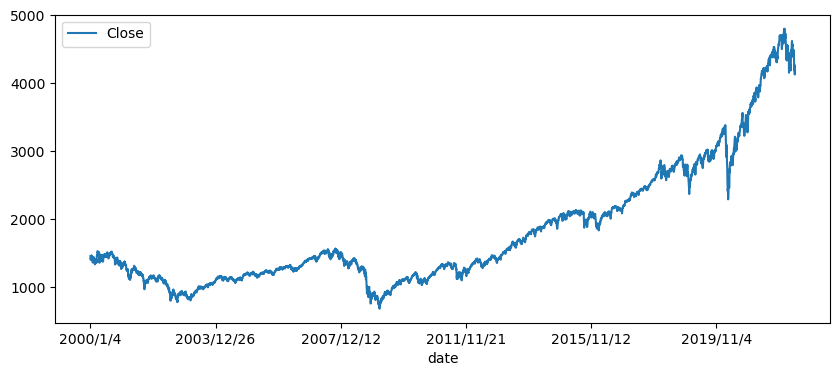

In [14]:
raw_data['Close'].plot(figsize=(10,4), legend=True)

## 2. 生成日收益率序列

利用日收盘价序列$Close_t$构造日收益率序列$DailyReturn_t$

$$
DailyReturn_t = \frac{Close_t-Close_{t-1}}{Close_{t-1}}
$$

In [15]:
data = pd.DataFrame()
data['Close'] = raw_data['Close'] 
data['DailyReturn'] = (raw_data['Close'] - raw_data['Close'].shift(1))/raw_data['Close'].shift(1)
data = data.dropna()
data.head(5)

,Close,DailyReturn
date,,
2000/1/5,1399.42,-0.038345
2000/1/6,1402.11,0.001922
2000/1/7,1403.45,0.000956
2000/1/10,1441.47,0.027090
2000/1/11,1457.60,0.011190


绘制$DailyReturn_t$，发现其符合时间序列平稳性的特征，有时候我们也会对收益率做对数处理。

<AxesSubplot:xlabel='date'>

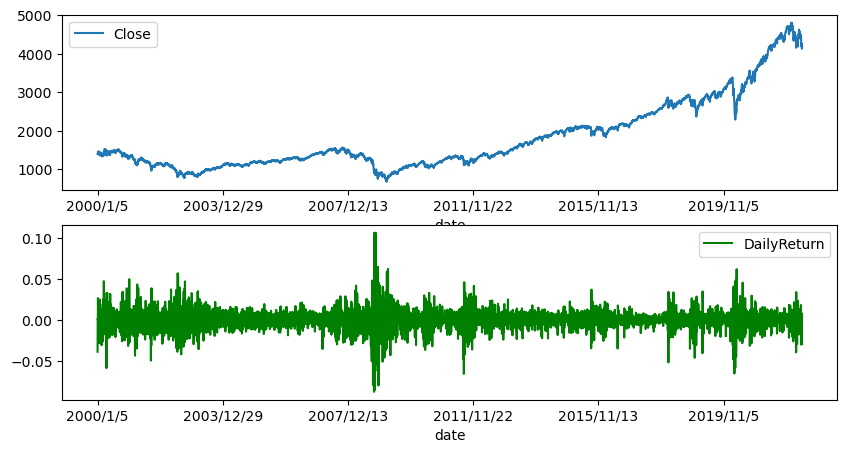

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
data[['Close']].plot(figsize=(10,5), ax=ax[0])
data[['DailyReturn']].plot(figsize=(10,5), ax=ax[1], color='green')

对收益率做对数处理的方法如下：
```python
data['LogReturn'] = (data['Close']/data['Close'].shift(1)).apply(np.log)
data = data.dropna()
```

## 3. 平稳性检验

使用ADF单位根检验（Augmented Dickey-Fuller unit root test）来检验日收益率序列是否平稳。

In [33]:
import statsmodels.tsa.stattools as st
adf_t, pvalue, usedlag, nobs, critical_values, icbest = \
        st.adfuller(data['DailyReturn'])
print('adf的t统计量：', adf_t)
print('p值：', pvalue)
print('滞后阶数：', usedlag)
print('样本数：', nobs)
print('临界值：', critical_values)

adf的t统计量： -14.148557458141616
p值： 2.1822548097162176e-26
滞后阶数： 33
样本数： 5595
临界值： {'1%': -3.431519312371081, '5%': -2.8620567217204944, '10%': -2.5670450495183927}


上述结果，p值通过检验，日收益率序列是平稳的。

## 4. 应用statsmodels构建自回归模型

In [18]:
import statsmodels.tsa.ar_model as ar_model
import numpy as np
model = ar_model.AutoReg(data['DailyReturn'], lags=1)
result = model.fit()
result.summary()

/Users/hans/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hans/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:1064: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(lag_repr) ** -1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            DailyReturn   No. Observations:                 5629
Model:                     AutoReg(1)   Log Likelihood               17112.757
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Mon, 28 Nov 2022   AIC                         -34219.514
Time:                        20:44:16   BIC                         -34199.608
Sample:                             1   HQIC                        -34212.579
                                 5629                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0003      0.000      1.745      0.081   -3.31e-05       0.001
DailyReturn.L1    -0.0298      0.013     -2.241      0.025      -0.056      -0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -33.5211           +0.0000j           33.5211            0.5000
-----------------------------------------------------------------------------
"""

也可以使用我们已经熟悉的回归分析的OLS来回归：

In [34]:
import statsmodels.api as sm
data['Intercept'] = 1.
model = sm.OLS(data['DailyReturn'].iloc[1:], \
            data[['Intercept', 'DailyReturn']].shift(1).iloc[1:])
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            DailyReturn   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.021
Date:                Wed, 30 Nov 2022   Prob (F-statistic):             0.0251
Time:                        09:22:30   Log-Likelihood:                 17113.
No. Observations:                5628   AIC:                        -3.422e+04
Df Residuals:                    5626   BIC:                        -3.421e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0003      0.000      1.745      0.081   -3.33e-05       0.001
DailyReturn    -0.0298      0.013     -2.241      0.025      -0.056      -0.004
==============================================================================
Omnibus:                      886.390   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14747.227
Skew:                          -0.167   Prob(JB):                         0.00
Kurtosis:                      10.923   Cond. No.                         86.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

观察自回归系数的p值小于5%，所以在5%显著性水平下，AR(1)模型是显著的。但是观察$R^2=0.001$，回归效果很差，自回归只解释了0.1%的信息。

根据上面回归结果，构造AR(1)自回归模型如下：

$$
DailyReturn_t = 0.0003-0.0298DailyReturn_{t-1} + u_t
$$


使用matplotlib绘图，并查看AR(1)模型的预测结果，及残差序列Residual，见下图。

<AxesSubplot:xlabel='date'>

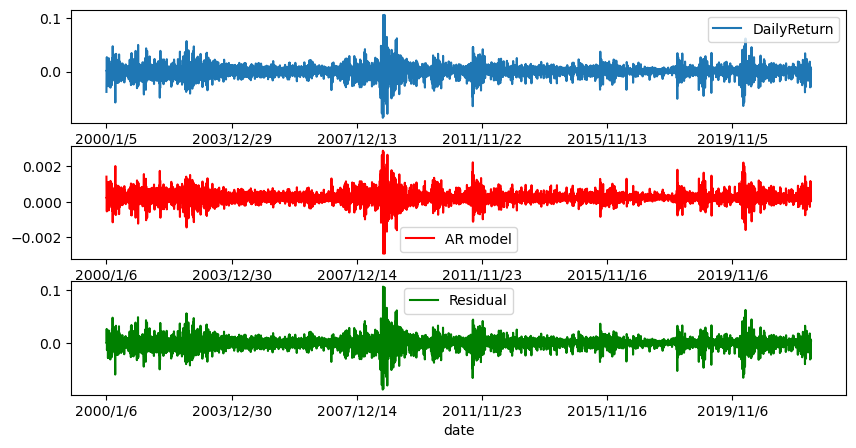

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,1)
data[['DailyReturn']].plot(figsize=(10,5), ax=ax[0])
result.fittedvalues.plot(figsize=(10,5), ax=ax[1],
                         label='AR model', color='red', legend=True)
result.resid.plot(figsize=(10,5), ax=ax[2],
                  label='Residual', color='green', legend=True)

当选择08年金融危机后的标普500指数到2022年这个时间段，会发现回归系数在5%显著性水平下不再显著。

In [29]:
import statsmodels.tsa.ar_model as ar_model
import numpy as np
model = ar_model.AutoReg(data[data.index>'2008/01/01']['DailyReturn'], lags=1)
result = model.fit()
result.summary()

/Users/hans/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hans/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:1064: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(lag_repr) ** -1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            DailyReturn   No. Observations:                 3617
Model:                     AutoReg(1)   Log Likelihood               10909.749
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Mon, 28 Nov 2022   AIC                         -21813.499
Time:                        20:46:28   BIC                         -21794.920
Sample:                             1   HQIC                        -21806.879
                                 3617                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0004      0.000      1.876      0.061   -1.66e-05       0.001
DailyReturn.L1    -0.0273      0.017     -1.644      0.100      -0.060       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -36.5982           +0.0000j           36.5982            0.5000
-----------------------------------------------------------------------------
"""

这说明了什么？请结合学过的金融知识，尝试解释这一实证结果。